# Analysis of the relationship between order satisfaction and delivery delay

In the e-commerce context, delivery timeliness is an important factor affecting user experience.

This section of analysis will validate:

1. Are late orders more likely to generate bad reviews?
2. Is there a statistically significant relationship between latency and satisfaction?

In [1]:
# 1. Read data
import pandas as pd
from src.utils.db import get_engine

# build SQLAlchemy Engine
engine = get_engine()

# sql
sql = """
SELECT
    is_satisfied,
    is_delayed,
    review_score
FROM view_order_complete
WHERE is_delayed IS NOT NULL
"""

# read data
df = pd.read_sql(sql, engine)

engine.dispose()

# check data
df.head()

,is_satisfied,is_delayed,review_score
0,1,0,5.0
1,1,0,4.0
2,1,0,5.0
3,1,0,4.0
4,1,0,5.0


In [3]:
# Check what the sample size is
df.shape

(115446, 3)

In [4]:
# check what the satisfied is/ Check the delayed rate
df['is_satisfied'].value_counts(normalize=True)
df['is_delayed'].value_counts(normalize=True)

is_delayed
0    0.934619
1    0.065381
Name: proportion, dtype: float64

# Since both is_delayed and is_satisfied types are 0, 1, both are categorical variables.
We need to see if there is a relationship between delayed and satisfied, so the first step is to make a "cross-statistical table"(synopsis)

In [5]:
# Make a synopsis
ct = pd.crosstab(df['is_delayed'], df['is_satisfied'])
ct

is_satisfied,0,1
is_delayed,,
0,22272,85626
1,5617,1931


In [6]:
# Calculate the satisfaction percentage for each row
ct_pct = ct.div(ct.sum(axis=1), axis=0)
ct_pct


is_satisfied,0,1
is_delayed,,
0,0.206417,0.793583
1,0.744171,0.255829


# Explanation: Delivery delay has a substantial negative impact on customer satisfaction.
From the contingency table analysis:
In an undelayed order: 85,626 orders satisfied/ 22,272 were dissatisfied
In a delayed order: 1,931 orders satisfied/ 5,617 orders were dissatisfied
ct_pct: Undelayed orders: Satisfaction Rate ≈ 79%
Delayed Orders: Satisfaction Rate ≈ 25%
**The satisfaction rate decreased by 54 percentage points**
This suggests that late orders are almost three times more likely to cause dissatisfaction than non-late orders.
The sheer extent of this difference suggests that shipping time is a key determinant of customer satisfaction in the e-commerce environment.


In [7]:
# Chi_square test (p<o.o5:There is a significant relationship/p>=0.05:There isn't a significant relationship)
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(ct)

print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 11131.4647219686
p-value: 0.0


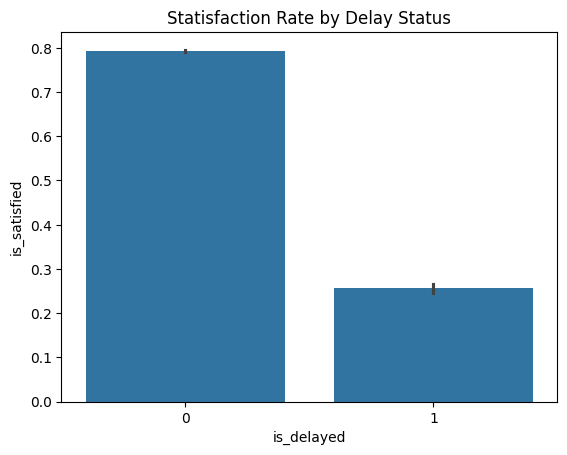

In [8]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='is_delayed', y='is_satisfied', data=df)
plt.title("Statisfaction Rate by Delay Status")
plt.show()

# Statistical Test Result

The chi-square test indicates an extremely significant relationship between delivery delay and customer satisfaction (**χ² = 11131.46, p < 0.001**).

Given the very small p-value, we reject the null hypothesis of independence and conclude that delivery delay is strongly associated with customer satisfaction.

Combined with the descriptive analysis (**79% satisfaction for non-delayed orders vs 25% for delayed orders**), delivery timeliness appears to be one of the most critical drivers of customer experience.
The chi-square statistic (χ² = 11131.46) measures the discrepancy between the observed frequencies and the expected frequencies under the assumption that delivery delay and customer satisfaction are independent.

A large χ² value indicates that the observed distribution deviates substantially from what would be expected if the two variables were unrelated.

In this case, the extremely large χ² value reflects the substantial difference in satisfaction rates between delayed and non-delayed orders.

Combined with a near-zero p-value (p < 0.001), the result provides strong statistical evidence that delivery delay and customer satisfaction are not independent.

In [11]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
import numpy as np

# prepare x and y
x = df[['is_delayed']]  #Independent variable
y = df['is_satisfied'] # dependent variable

# build model
model = LogisticRegression()
# training model
model.fit(x, y)

# check coefficient
beta_1 = model.coef_[0][0]
beta_0 = model.intercept_[0]

print("β1：", beta_1)
print("β0：", beta_0)

β1： -2.41268680388846
β0： 1.3465855320000364


In [12]:
# calculate odds ratio
odds_ratio = np.exp(beta_1)
print(odds_ratio)
# The satisfied odds for late orders are only 0.089 times higher than for non-late orders.

0.08957430238389727


# Logistic regression ama;ysis
Logistic regression analysis was conducted to examine the impact of delivery delay on customer satisfaction. The estimated coefficient for delivery delay (β₁ = -2.41) is negative, indicating that delayed orders substantially reduce the log-odds of customer satisfaction. In logistic regression, coefficients represent changes in log-odds; therefore, a negative β₁ suggests that the probability of satisfaction decreases when an order is delayed.

Transforming the coefficient into an odds ratio provides a more intuitive interpretation. The odds ratio of 0.089 (exp(-2.41)) indicates that the odds of receiving a positive satisfaction rating for delayed orders are only 8.9% of those for non-delayed orders. In other words, delayed orders are approximately 11 times less likely to result in customer satisfaction compared to on-time deliveries.

The intercept term (β₀ = 1.35) represents the baseline log-odds of satisfaction when the order is not delayed. Converting this value into probability yields an estimated satisfaction rate of approximately 79% for non-delayed orders. **When an order is delayed, the predicted satisfaction probability drops dramatically to around 26%**.

These findings quantitatively demonstrate that delivery timeliness is a critical determinant of customer satisfaction in the e-commerce context.

In [16]:
sql="""
SELECT
    CASE
        WHEN review_score >= 4 THEN 1
        ELSE 0
    END AS is_satisfied,
    is_delayed,
    delivered_days,
    order_value
FROM view_delivery_analysis
WHERE delivered_days IS NOT NULL
    AND review_score IS NOT NULL
"""
df= pd.read_sql(sql, engine)
df.head()

,is_satisfied,is_delayed,delivered_days,order_value
0,1,0,7,72.19
1,1,0,16,259.83
2,1,0,8,216.87
3,1,0,6,25.78
4,1,0,25,218.04


In [20]:
# Multivariate Logistic Regression
# y = is_satisfied
# After controlling for other variables, each variable independently affects satisfaction.

# prepare data
features = [
    'delivered_days',
    'order_value'
]

df_model = df.dropna(subset=features + ['is_satisfied'])
x = df_model[features]
y = df_model['is_satisfied']
df_model.describe()

,is_satisfied,is_delayed,delivered_days,order_value
count,95602.000000,95602.000000,95602.000000,95602.000000
mean,0.789868,0.066547,12.451884,159.571981
std,0.407404,0.249237,9.466435,217.454942
min,0.000000,0.000000,0.000000,9.590000
25%,1.000000,0.000000,7.000000,61.800000
50%,1.000000,0.000000,10.000000,105.280000
75%,1.000000,0.000000,16.000000,176.160000
max,1.000000,1.000000,208.000000,13664.080000


In [22]:
# Multivariate Logistic Regression
from sklearn.linear_model import LogisticRegression
# Split data into training/test sets
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,      # 20% is used for the test set.
    random_state=42,    # Fix random seeds to ensure consistent results every time # Stratified sampling at the scale of y (avoid significant imbalance)
    stratify=y
)

# train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

# check model coefficient
beta = model.coef_[0]
beta0 = model.intercept_[0]

print("β0 (intercept):", beta0)
for name, b in zip(features, beta):
    print(f"β for {name}:", b)


β0 (intercept): 2.35439465394746
β for delivered_days: -0.07389072186802492
β for order_value: -0.00012283275361339892


In [23]:
# calculate odds ratio
odds_ratios = np.exp(beta)

for name, or_val in zip(features, odds_ratios):
    print(f"Odds Ratio for {name}: {or_val}")

Odds Ratio for delivered_days: 0.9287731828943744
Odds Ratio for order_value: 0.9998771747900204


In [25]:
# check predict result
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy on test set:", acc)
print("Confusion matrix:\n", cm)

Accuracy on test set: 0.8124575074525391
Confusion matrix:
 [[  598  3420]
 [  166 14937]]


# Multivariate logistic regression analysis
Multivariate logistic regression shows that delivery duration has a statistically significant negative impact on customer satisfaction. **Each additional delivery day reduces the odds of satisfaction by approximately 7%**. In contrast, order value has a negligible effect on satisfaction. **Although the overall model accuracy reaches 81%**, the confusion matrix reveals poor performance in identifying dissatisfied orders, suggesting class imbalance and the need for model adjustment.

In [27]:
# Advanced statistics (Because of the high accuracy, the judgment model is almost always predicted to be satisfactory)
# However, their ability to detect dissatisfaction is quite poor.
from sklearn.linear_model import LogisticRegression

model_bal = LogisticRegression(class_weight='balanced')
model_bal.fit(x_train, y_train)

# predict
y_pred_bal = model_bal.predict(x_test)

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc_bal = accuracy_score(y_test, y_pred_bal)
cm_bal = confusion_matrix(y_test, y_pred_bal)

print("Balanced Accuracy:", acc_bal)
print("Balanced Confusion Matrix:\n", cm_bal)

Balanced Accuracy: 0.6746509073793212
Balanced Confusion Matrix:
 [[ 2052  1966]
 [ 4255 10848]]


In [34]:
# More advanced show
# get predict rate (use predict_proba to returns the predicted probability for each category)
y_prob = model_bal.predict_proba(x_test)[:, 1]
# [:, 1] get most satisfying

# calculate ROC, Receiver Operating Characteristic
# Observe how the model behaves when we change the classification gap
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2869792980.py, line 12)

In [36]:
roc_df = pd.DataFrame({
    "threshold": threshold,
    "FPR": fpr,
    "TPR": tpr
})

roc_df.head(10)

,threshold,FPR,TPR
0,inf,0.000000,0.000000
1,0.716197,0.000000,0.000066
2,0.716138,0.000000,0.000199
3,0.716120,0.000000,0.000331
4,0.716006,0.000000,0.000530
5,0.715975,0.000249,0.000596
6,0.715966,0.000249,0.000728
7,0.715733,0.000249,0.001589
8,0.715706,0.000249,0.001722
9,0.715494,0.000249,0.002384


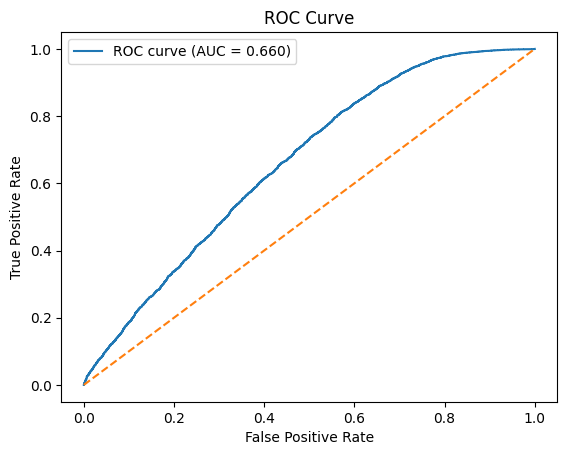

AUC: 0.6596911346467876


In [35]:
# draw
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label = "ROC curve (AUC = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
print("AUC:", roc_auc)

# analysis
,I trained a multivariate logistic regression model to predict customer satisfaction (is_satisfied) using delivery duration (delivered_days) and order value (order_value) as predictors. The ROC curve on the test set yields an **AUC of 0.660**, which is clearly above the random baseline of 0.5. This indicates that the model has non-trivial discriminative power between satisfied and dissatisfied orders. However, the curve still lies relatively close to the diagonal and does not approach the top-left corner, suggesting only moderate predictive performance. **In practice, this means that delivery time and order value are relevant but not sufficient on their own to accurately predict satisfaction.**
 Additional features (e.g. product category, service interactions, return events) would be needed to build a stronger model.

In [37]:
# Compare Random Forest Model
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators = 200,
    max_depth = None,
    random_state = 42
)

rf_model.fit(x_train, y_train)

# predict probability
rf_prob = rf_model.predict_proba(x_test)[:, 1]

# calculate ROC and AUC
from sklearn.metrics import roc_curve, auc

rf_fpr, rf_tpr, _=roc_curve(y_test, rf_prob)
rf_auc = auc(rf_fpr, rf_tpr)

print("Random Forest AUC:", rf_auc)


Random Forest AUC: 0.6004998215835138


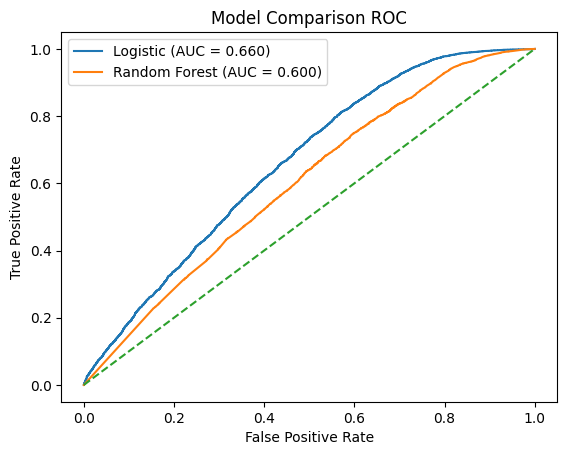

In [38]:
# draw
import matplotlib.pyplot as plt

plt.figure()

plt.plot(fpr, tpr, label=f"Logistic (AUC = {roc_auc:.3f})")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.3f})")

plt.plot([0,1],[0,1],'--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Model Comparison ROC")
plt.legend()
plt.show()

# Random Forest Model
Model comparison shows that Logistic Regression (AUC = 0.660) outperforms Random Forest (AUC = 0.600) in predicting customer satisfaction. This suggests that the relationship between delivery duration and satisfaction is largely linear and monotonic, which favors linear models. The limited number of input features also restricts the potential advantage of non-linear models. Therefore, Logistic Regression remains the preferred model under the current feature setting.

In [ ]:
# optimize threshold
# Hypothesis: A satisfactory order is misjudged as "unsatisfactory" and cost = 3 pounds (manual contact cost)
# Missing a real unsatisfactory order: cost = 50 pounds (bad reviews + churn)
# So it is necessary to check for missed unhappy customers (FN)
